## Table of Contents

- [A first look at raw data](#a-first-look-at-the-raw-data)
    - [Customer ID](#a-first-look-at-customerid)
    - [Age](#a-first-look-at-age)
    - [Gender](#a-first-look-gender)
    - [Tenure](#a-first-look-tenure)
    - [Usage Frequency](#a-first-look-usage-frequency)
    - [Support Calls](#a-first-look-support-calls)
    - [Subscription Types](#a-first-look-subscription-types)
    - [Payment Delays](#a-first-look-payment-delays)
    - [Contract Length](#a-first-look-contract-length)
    - [Total Spend](#a-first-look-total-spend)
    - [Churn](#a-first-look-churn)
- [Training vs Test distributions](#comparison-of-distributions-between-training-and-test-datasets)
- [Handling missing values](#handling-missing-values)

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set seed for reproducibility
np.random.seed(0) 

train = pd.read_csv('data/customer_churn_dataset-training-master.csv')
test = pd.read_csv('data/customer_churn_dataset-testing-master.csv')

## A first look at the raw data

Before doing any handling of missing values, I always find it really useful to examine the column types and their associated unique values. 

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64368 non-null  object
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64368 non-null  object
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64371 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(7), object(5)
memory usage: 5.9+ MB


We notice the column types differ between the training and test datasets. 

In particular, all `float64` columns in training set were parsed as `int64` in test set, except for 2 of them, which were parsed as `object`s:
- Age: `float64` -> `object`
- Support Calls: `float64` -> `object`

This could be a sign that:
- Some values in those 2 columns of the test set have incoherent "intrinsic" types. 
- It could also be a hint that the training set has missing values.

Let's further investigate, but first, let's clean up the column names.

In [5]:
train.columns = [c.replace(" ","") for c in train.columns] 
test.columns = [c.replace(" ","") for c in test.columns] 
assert (train.columns == test.columns).all()
print(train.columns)

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'UsageFrequency',
       'SupportCalls', 'PaymentDelay', 'SubscriptionType', 'ContractLength',
       'TotalSpend', 'LastInteraction', 'Churn'],
      dtype='object')


### A first look at CustomerID

Are all CustomerID values integers or do we have anomalous values with decimal parts?

In [6]:
train[~train.CustomerID.apply(lambda x: x.is_integer())]    

,CustomerID,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,SubscriptionType,ContractLength,TotalSpend,LastInteraction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The CustomerID field in the training set only contains integers and a single NaN value (which is why it was parsed as a `float64` column). Meanwhile, the CustomerID field in the test set was parsed as an `int64` and does not contain missing values.

In [7]:
test.CustomerID.isna().sum()

0

### A first look at Age

In [8]:
train.Age.describe()

count    440832.000000
mean         39.373153
std          12.442369
min          18.000000
25%          29.000000
50%          39.000000
75%          48.000000
max          65.000000
Name: Age, dtype: float64

In [9]:
train.Age.unique()

array([30., 65., 55., 58., 23., 51., 39., 64., 29., 52., 22., 48., 24.,
       49., 19., 47., 42., 57., 27., 59., 21., 60., 35., 18., 56., 20.,
       63., 25., 28., 32., 38., 37., 31., 53., 41., 33., 26., 36., 44.,
       34., 61., 40., 45., 46., 54., 43., 50., 62., nan])

In [10]:
train.Age.isna().sum()

1

In [11]:
test.Age.describe()

count     64368
unique       56
top          55
freq       1486
Name: Age, dtype: object

In [12]:
test.Age.unique()

array(['22', '41', '47', '35', '53', '30', '54', '36', '65', '46', '56',
       '31', '42', '59', '29', '45', '62', '48', '55', '64', '25', '44',
       '28', '34', '24', '27', '61', '57', '37', '51', '18', '23', '60',
       '40', '26', '52', nan, '43', '19', '58', '33', '20', '39', '32',
       '38', '21', '63', '49', '50', 'Twenty-nine', '0', 'sixty',
       'forty-seven', 'fifty eight', 'twenty five', 'twenty seven',
       'forty six'], dtype=object)

We can see the test column has word representations of numbers. It could be interesting to use a package such as `word2number` to transform those all at once, but because there are not so many we can simply map them back manually to their numeric representation.

In [13]:
words_to_nums = {
    'Twenty-nine':29,
    'sixty':60,
    'forty-seven': 47, 
    'fifty eight': 48,
    'twenty five': 25,
    'twenty seven': 27,
    'forty six': 46
}

def map_nums(x):
    if pd.notnull(x):
        if x in words_to_nums:
            return words_to_nums[x]
        else:
            return float(x)
    else:
        return x

AgeCleaned = test.Age.apply(map_nums)


In [14]:
AgeCleaned.describe()

count    64368.000000
mean        41.969612
std         13.925750
min          0.000000
25%         30.000000
50%         42.000000
75%         54.000000
max         65.000000
Name: Age, dtype: float64

In [15]:
AgeCleaned.unique()

array([22., 41., 47., 35., 53., 30., 54., 36., 65., 46., 56., 31., 42.,
       59., 29., 45., 62., 48., 55., 64., 25., 44., 28., 34., 24., 27.,
       61., 57., 37., 51., 18., 23., 60., 40., 26., 52., nan, 43., 19.,
       58., 33., 20., 39., 32., 38., 21., 63., 49., 50.,  0.])

In [16]:
test.Age = AgeCleaned

In [17]:
test.Age.isna().sum()

6

### A first look: Gender

In [18]:
train.Gender.describe()

count     440832
unique         2
top         Male
freq      250252
Name: Gender, dtype: object

In [19]:
train.Gender.unique()

array(['Female', 'Male', nan], dtype=object)

In [20]:
train.Gender.isna().sum()

1

In [21]:
test.Gender.describe()

count      64374
unique         4
top       Female
freq       34352
Name: Gender, dtype: object

In [22]:
test.Gender.unique()

array(['Female', 'Male', 'Man', 'Woman'], dtype=object)

In [23]:
test.Gender.value_counts()

Gender
Female    34352
Male      30020
Man           1
Woman         1
Name: count, dtype: int64

In the grand scheme of things, that inconsistency on the Gender test set is not a huge deal, but let's clean it up with a simple mapping. 

In [24]:
gender_map = {
    'Man': 'Male',
    'Woman': 'Female'
}

def map_gender(x):
    if pd.notnull(x):
        if x in gender_map:
            return gender_map[x]
        else:
            return x
    else:
        return x

GenderCleaned = test.Gender.apply(map_gender)

In [25]:
GenderCleaned.unique()

array(['Female', 'Male'], dtype=object)

In [26]:
test.Gender = GenderCleaned

In [27]:
test.Gender.isna().sum()

0

### A first look: Tenure

In [28]:
train.Tenure.describe()

count    440832.000000
mean         31.256336
std          17.255727
min           1.000000
25%          16.000000
50%          32.000000
75%          46.000000
max          60.000000
Name: Tenure, dtype: float64

In [29]:
train.Tenure.unique()

array([39., 49., 14., 38., 32., 33., 37., 12.,  3., 18., 21., 41., 35.,
        4., 56., 44., 15., 55., 43., 52., 26.,  2., 29., 59., 40., 51.,
       53., 24., 30.,  6., 28., 17., 60.,  7., 34., 10.,  5., 45., 54.,
       58., 25., 13., 47., 31., 22., 19., 23.,  1.,  8., 46., 16., 50.,
       48., 11., 42., 27.,  9., 20., 57., 36., nan])

In [30]:
train.Tenure.isna().sum()

1

No major surprises: all values are integers except for a single missing one.

In [31]:
test.Tenure.describe()

count    64374.000000
mean        31.994827
std         17.098234
min          1.000000
25%         18.000000
50%         33.000000
75%         47.000000
max         60.000000
Name: Tenure, dtype: float64

In [32]:
test.Tenure.unique()

array([25, 28, 27,  9, 58, 41, 37, 36, 20,  8, 42, 13,  2, 46, 21,  1, 54,
       40, 39, 50, 59, 60, 44, 23, 26, 31, 30, 51, 45, 19, 14, 24, 15, 47,
        3, 17, 22, 57, 34, 29, 33, 35, 56,  5, 55, 48,  6, 32, 16, 10,  7,
       43, 52, 53, 38,  4, 11, 18, 49, 12])

### A first look: Usage Frequency

In [33]:
train.UsageFrequency.describe()

count    440832.000000
mean         15.807494
std           8.586242
min           1.000000
25%           9.000000
50%          16.000000
75%          23.000000
max          30.000000
Name: UsageFrequency, dtype: float64

In [34]:
train.UsageFrequency.unique()

array([14.,  1.,  4., 21., 20., 25., 12.,  8.,  5.,  9.,  6., 17., 23.,
       13., 16., 27.,  2., 28., 29., 15., 24.,  3., 22., 26., 30.,  7.,
       11., 18., 19., 10., nan])

In [35]:
train.UsageFrequency.isna().sum()

1

In [36]:
test.UsageFrequency.describe()

count    64374.000000
mean        15.080234
std          8.816470
min          1.000000
25%          7.000000
50%         15.000000
75%         23.000000
max         30.000000
Name: UsageFrequency, dtype: float64

In [37]:
test.UsageFrequency.unique()

array([14, 28, 10, 12, 24, 15, 11,  5,  4, 27, 23,  7, 17,  3, 30,  2, 19,
       20, 18,  8,  6, 21, 26, 16, 25, 13, 29,  9, 22,  1])

### A first look: Support Calls

Let's do the same with Support Calls.

In [38]:
train.SupportCalls.describe()

count    440832.000000
mean          3.604437
std           3.070218
min           0.000000
25%           1.000000
50%           3.000000
75%           6.000000
max          10.000000
Name: SupportCalls, dtype: float64

In [39]:
train.SupportCalls.unique()

array([ 5., 10.,  6.,  7.,  9.,  3.,  4.,  2.,  0.,  1.,  8., nan])

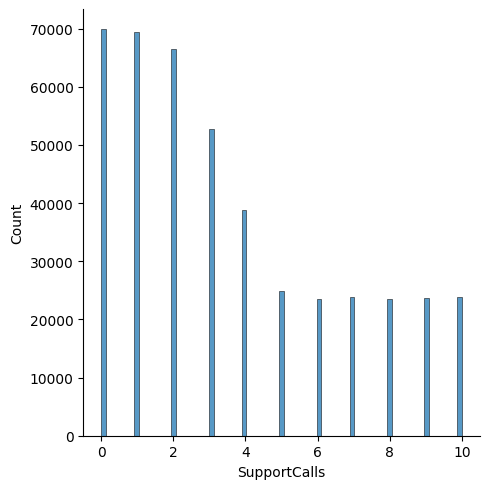

In [40]:
sns.displot(train,x='SupportCalls')

In [41]:
test.SupportCalls.describe()

count     64368
unique       16
top           9
freq       6661
Name: SupportCalls, dtype: object

In [42]:
test.SupportCalls.unique()

array(['4', '7', '2', '5', '9', '10', '0', '6', '1', '3', '8', nan, 'two',
       'none', 'seven', '10+', 'nine'], dtype=object)

Interesting! It is straightforward to map back most litterals to a numeric value, but the '10+' value is a tricky one! Also, we don't have values greater than 10 in our training set, so whatever model we train will struggle to generalize well when presented with values greater than 10.

- A first approach could be to map '10+' to numeric value 10. 
- another approach could be to randomize a long tail of values greater than 10, to complete the right side of the distribution of Support Calls as seen on the training set, as a half bell curve. 

We will adopt the former suggestion for the sake of simplicity.

In [43]:
words_to_nums = {
    'two': 2,
    'none': float('nan'),
    'seven': 7, 
    '10+': 10,
    'nine': 9
}

def map_nums(x):
    if pd.notnull(x):
        if x in words_to_nums:
            return words_to_nums[x]
        else:
            return float(x)
    else:
        return x

SupportCallsCleaned = test.SupportCalls.apply(map_nums)

In [44]:
SupportCallsCleaned.unique()

array([ 4.,  7.,  2.,  5.,  9., 10.,  0.,  6.,  1.,  3.,  8., nan])

In [45]:
test.SupportCalls = SupportCallsCleaned

In [46]:
test.SupportCalls.describe()

count    64367.000000
mean         5.400718
std          3.113956
min          0.000000
25%          3.000000
50%          6.000000
75%          8.000000
max         10.000000
Name: SupportCalls, dtype: float64

### A first look: Payment Delays

In [47]:
train.PaymentDelay.describe()

count    440832.000000
mean         12.965722
std           8.258063
min           0.000000
25%           6.000000
50%          12.000000
75%          19.000000
max          30.000000
Name: PaymentDelay, dtype: float64

In [48]:
train.PaymentDelay.unique()

array([18.,  8.,  7., 26., 16., 15.,  4., 11., 30., 25., 13., 22.,  5.,
       14.,  3., 10., 28.,  2.,  6., 27., 12., 29., 17., 24.,  9., 23.,
       21.,  1.,  0., 20., 19., nan])

In [49]:
train.PaymentDelay.isna().sum()

1

In [50]:
test.PaymentDelay.describe()

count    64374.000000
mean        17.133952
std          8.852211
min          0.000000
25%         10.000000
50%         19.000000
75%         25.000000
max         30.000000
Name: PaymentDelay, dtype: float64

In [51]:
test.PaymentDelay.unique()

array([27, 13, 29, 17,  2, 10, 28, 18,  8, 23, 21, 14, 25,  3,  6, 15,  1,
        9, 30,  4,  0, 11, 16,  7, 24, 22, 12, 26, 20, 19,  5])

### A first look: Subscription Types

In [52]:
train.SubscriptionType.describe()

count       440832
unique           3
top       Standard
freq        149128
Name: SubscriptionType, dtype: object

In [53]:
train.SubscriptionType.unique()

array(['Standard', 'Basic', 'Premium', nan], dtype=object)

In [54]:
train.SubscriptionType.isna().sum()

1

In [55]:
test.SubscriptionType.describe()

count        64371
unique           3
top       Standard
freq         21501
Name: SubscriptionType, dtype: object

In [56]:
test.SubscriptionType.unique()

array(['Basic', 'Standard', 'Premium', nan], dtype=object)

In [57]:
test.SubscriptionType.isna().sum()

3

### A first look: Contract Length

In [58]:
train.ContractLength.describe()

count     440832
unique         3
top       Annual
freq      177198
Name: ContractLength, dtype: object

In [59]:
train.ContractLength.unique()

array(['Annual', 'Monthly', 'Quarterly', nan], dtype=object)

In [60]:
train.ContractLength.isna().sum()

1

In [61]:
test.ContractLength.describe()

count       64374
unique          6
top       Monthly
freq        22128
Name: ContractLength, dtype: object

In [62]:
test.ContractLength.unique()

array(['Monthly', 'Annual', 'Quarterly', 'Q3', '12 months',
       'Once a month'], dtype=object)

In [63]:
test.ContractLength.value_counts()

ContractLength
Monthly         22128
Annual          21410
Quarterly       20833
Q3                  1
12 months           1
Once a month        1
Name: count, dtype: int64

Again, we have a few exotic values in the test set for the Contract Length, but that only relates to 3 records. Nevertheless, we fix them up!

In [64]:
test.ContractLength.isna().sum()

0

In [65]:
type_map = {
    'Q3': 'Quarterly',
    '12 months': 'Annual',
    'Once a month': 'Monthly'
}

def fix(x):
    if pd.notnull(x):
        if x in type_map:
            return type_map[x]
        else:
            return x
    else:
        return x

ContractLengthCleaned = test.ContractLength.apply(fix)

In [66]:
ContractLengthCleaned.unique()

array(['Monthly', 'Annual', 'Quarterly'], dtype=object)

In [67]:
test.ContractLength = ContractLengthCleaned

### A first look: Total Spend

In [68]:
train.TotalSpend.describe()

count    440832.000000
mean        631.616223
std         240.803001
min         100.000000
25%         480.000000
50%         661.000000
75%         830.000000
max        1000.000000
Name: TotalSpend, dtype: float64

In [69]:
train.TotalSpend.unique()

array([932.  , 557.  , 185.  , ..., 829.59, 804.3 , 959.47])

In [70]:
train.TotalSpend.isna().sum()

1

In [71]:
test.TotalSpend.describe()

count    64374.000000
mean       541.023379
std        260.874809
min        100.000000
25%        313.000000
50%        534.000000
75%        768.000000
max       1000.000000
Name: TotalSpend, dtype: float64

In [72]:
test.TotalSpend.isna().sum()

0

### A first look: Last Interaction

In [73]:
train.LastInteraction.describe()

count    440832.000000
mean         14.480868
std           8.596208
min           1.000000
25%           7.000000
50%          14.000000
75%          22.000000
max          30.000000
Name: LastInteraction, dtype: float64

In [74]:
train.LastInteraction.unique()

array([17.,  6.,  3., 29., 20.,  8., 24., 30., 13., 18., 19., 23.,  4.,
       16., 10., 21., 22.,  2., 15., 28., 26.,  7.,  1.,  9.,  5., 14.,
       11., 12., 27., 25., nan])

In [75]:
train.LastInteraction.isna().sum()

1

In [76]:
test.LastInteraction.describe()

count    64374.000000
mean        15.498850
std          8.638436
min          1.000000
25%          8.000000
50%         15.000000
75%         23.000000
max         30.000000
Name: LastInteraction, dtype: float64

In [77]:
test.LastInteraction.isna().sum()

0

### A first look: Churn

In [78]:
train.Churn.describe()

count    440832.000000
mean          0.567107
std           0.495477
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: Churn, dtype: float64

In [79]:
train.Churn.unique()

array([ 1.,  0., nan])

In [80]:
train.Churn.isna().sum()

1

In [81]:
train.Churn.value_counts()

Churn
1.0    249999
0.0    190833
Name: count, dtype: int64

In [82]:
train.Churn.value_counts()[0]/(train.Churn.value_counts()[0]+train.Churn.value_counts()[1])

0.4328928027003484

In [83]:
test.Churn.describe()

count    64374.000000
mean         0.473685
std          0.499311
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Churn, dtype: float64

In [84]:
test.Churn.unique()

array([1, 0])

In [85]:
test.Churn.isna().sum()

0

In [86]:
test.Churn.value_counts()

Churn
0    33881
1    30493
Name: count, dtype: int64

In [87]:
test.Churn.value_counts()[1]/(test.Churn.value_counts()[0]+test.Churn.value_counts()[1])

0.47368502811694163

The test set has more churners than the training set (47.4% retained vs 43.2%).

## Comparison of distributions between training and test datasets

In [205]:
train.to_parquet('data/training.pq', index=False)
test.to_parquet('data/testing.pq', index=False)

train['dataset'] = 'train'
test['dataset'] = 'test'
alld = pd.concat([train,test]).reset_index()

<Axes: xlabel='Age', ylabel='Density'>

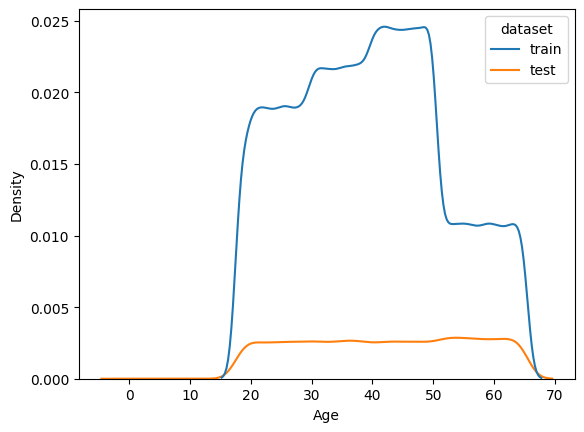

In [206]:
sns.kdeplot(alld,x='Age',hue='dataset')

<Axes: xlabel='Gender', ylabel='count'>

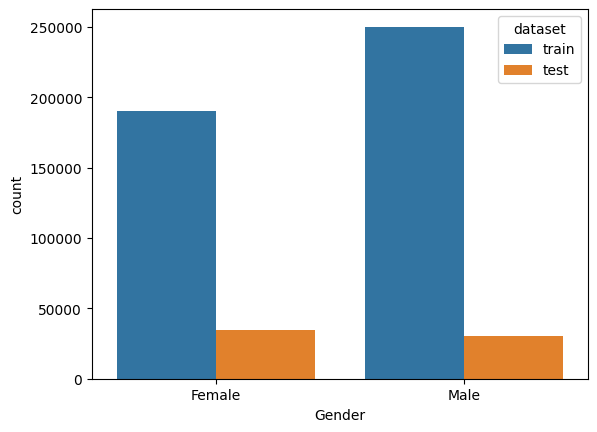

In [207]:
sns.countplot(alld,x='Gender',hue='dataset')

<Axes: xlabel='Tenure', ylabel='Density'>

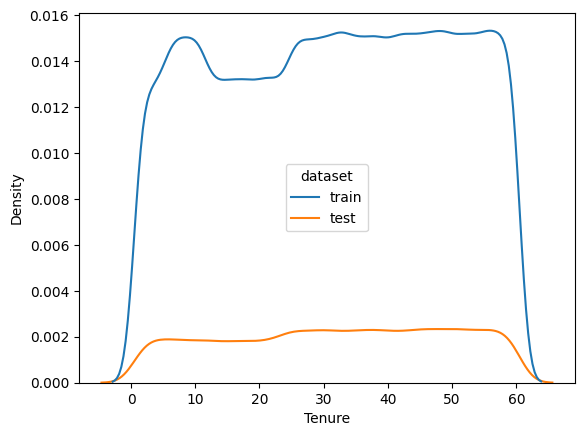

In [208]:
sns.kdeplot(alld,x='Tenure',hue='dataset')

<Axes: xlabel='UsageFrequency', ylabel='Density'>

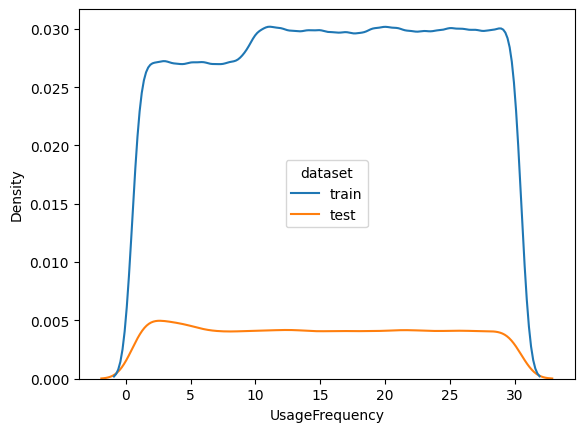

In [209]:
sns.kdeplot(alld,x='UsageFrequency',hue='dataset')

<Axes: xlabel='SupportCalls', ylabel='Density'>

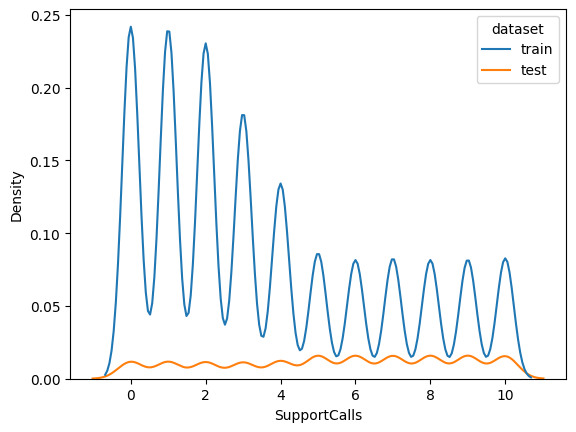

In [210]:
sns.kdeplot(alld, x='SupportCalls', hue='dataset')

<Axes: xlabel='PaymentDelay', ylabel='Density'>

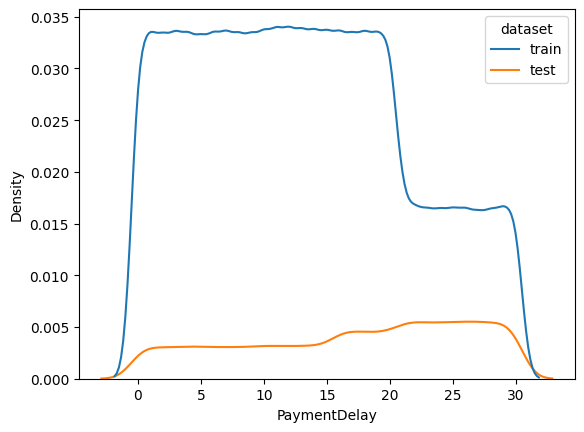

In [211]:
sns.kdeplot(alld, x='PaymentDelay', hue='dataset')

Looks like we are going to be testing against a distribution that exhibits an opposite skew.

<Axes: xlabel='SubscriptionType', ylabel='count'>

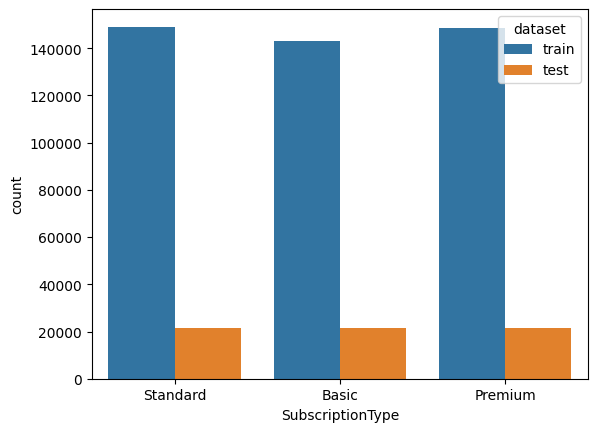

In [212]:
sns.countplot(alld,x='SubscriptionType',hue='dataset')

<Axes: xlabel='ContractLength', ylabel='count'>

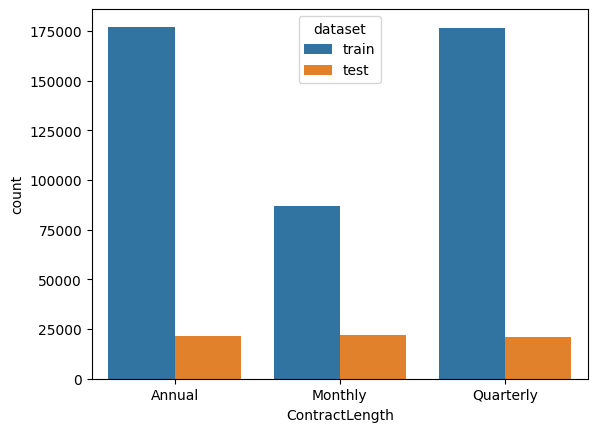

In [213]:
sns.countplot(alld,x='ContractLength',hue='dataset')

We will be testing against an over-representation of Monthly contracts.

<Axes: xlabel='TotalSpend', ylabel='Density'>

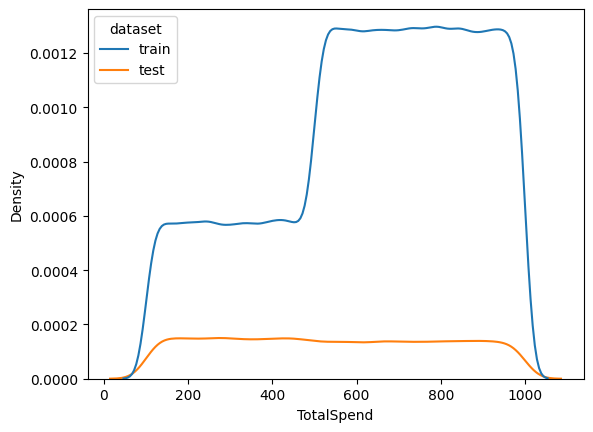

In [214]:
sns.kdeplot(alld, x='TotalSpend', hue='dataset')

Spend is rather uniform in test set, as opposed to bimodal in training set.

<Axes: xlabel='LastInteraction', ylabel='Density'>

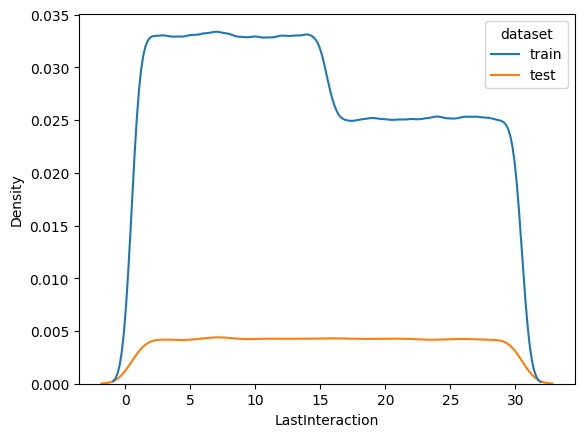

In [215]:
sns.kdeplot(alld, x='LastInteraction', hue='dataset')

<Axes: xlabel='Churn', ylabel='count'>

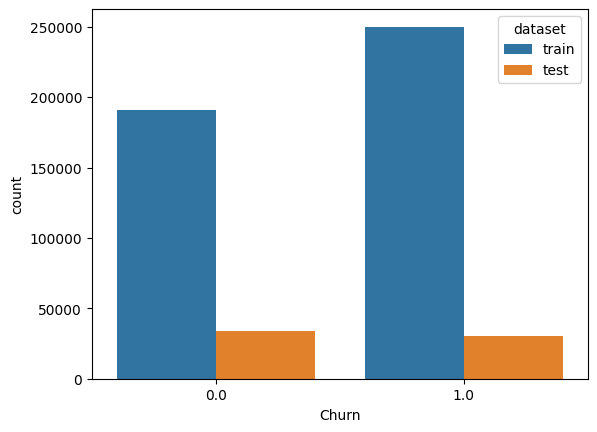

In [216]:
sns.countplot(alld,x='Churn',hue='dataset')

As seen before, we have opposite representation of churners.

## Handling missing values

We reload the datasets that we had previously staged with their minor fixes.

In [262]:
train = pd.read_parquet('data/training.pq')
test = pd.read_parquet('data/testing.pq')

In [263]:
train[train.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,SubscriptionType,ContractLength,TotalSpend,LastInteraction,Churn
199295,NaN,NaN,None,NaN,NaN,NaN,NaN,None,None,NaN,NaN,NaN


We simply drop the single record that has missing values on the training set.

In [264]:
train = train.dropna(how='all')

In [265]:
train[train.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,SubscriptionType,ContractLength,TotalSpend,LastInteraction,Churn


In [266]:
test[test.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,SubscriptionType,ContractLength,TotalSpend,LastInteraction,Churn
71,72,NaN,Female,34,20,1.0,1,Basic,Annual,986,19,0
72,73,52.0,Female,5,12,NaN,23,Basic,Annual,844,12,0
91,92,37.0,Female,57,21,NaN,6,Premium,Quarterly,209,29,0
104,105,NaN,Male,10,22,9.0,0,Standard,Quarterly,218,7,0
111,112,41.0,Male,8,11,NaN,24,Premium,Monthly,900,14,0
144,145,24.0,Male,8,12,NaN,15,Basic,Annual,257,18,0
160,161,36.0,Male,51,1,NaN,7,Premium,Annual,837,16,0
208,209,64.0,Male,13,20,NaN,22,Standard,Quarterly,749,14,0
385,386,NaN,Female,41,15,10.0,27,Premium,Quarterly,814,19,1
432,433,NaN,Female,9,19,4.0,26,Basic,Annual,805,21,0


In [267]:
test.Age = test.Age.fillna(test.Age.mean())
test.SupportCalls = test.SupportCalls.fillna(test.SupportCalls.mean())

In [268]:
test[test.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,SubscriptionType,ContractLength,TotalSpend,LastInteraction,Churn
487,488,46.0,Male,11,19,2.0,7,None,Quarterly,612,8,0
495,496,28.0,Male,60,16,9.0,7,None,Monthly,494,5,0
501,502,45.0,Male,7,30,7.0,25,None,Annual,978,29,0


In [269]:
test.SubscriptionType.value_counts(normalize=True) * 100

SubscriptionType
Standard    33.401687
Basic       33.320905
Premium     33.277408
Name: proportion, dtype: float64

In the absence of a clear mode for that variable on the test set, we could pick a random value for SubscriptionType, but instead we will simply drop those records from the test set.

In [270]:
test = test.dropna()
test[test.isna().any(axis=1)]

,CustomerID,Age,Gender,Tenure,UsageFrequency,SupportCalls,PaymentDelay,SubscriptionType,ContractLength,TotalSpend,LastInteraction,Churn


In [271]:
train.CustomerID = train.CustomerID.astype('int64')
train.Churn = train.Churn.astype('int64')
test.Tenure = test.Tenure.astype('float64')
test.UsageFrequency = test.UsageFrequency.astype('float64')
test.PaymentDelay = test.PaymentDelay.astype('float64')
test.TotalSpend = test.TotalSpend.astype('float64')
test.LastInteraction = test.LastInteraction.astype('float64')

In [272]:
(test.dtypes.values == train.dtypes.values).all()

True

In [273]:
train.to_parquet('data/training_2.pq', index=False)
test.to_parquet('data/testing_2.pq', index=False)